In [148]:
# updated dataframe and resources link
# https://drive.google.com/drive/folders/1U2sGpIXiRbuu2F9gdJf8YMzaVsDUenOv?usp=sharing

In [149]:
pip install emoji pyLDAvis pycld2 polyglot pyicu Morfessor ner python-twitter

In [150]:
!git clone https://github.com/channel960608/pynerer.git

fatal: destination path 'pynerer' already exists and is not an empty directory.


In [151]:
!cd pynerer; python3 setup.py install
#After running this command click Runtime >> Restart Runtime in order for colab to fetch freshly installed module

In [152]:
!cp "/content/drive/My Drive/twitter_creds.py" /content

cp: cannot stat '/content/drive/My Drive/twtter_creds.py': No such file or directory


In [153]:
import pandas as pd 
import nltk,spacy,re,emoji,pyLDAvis,requests,gensim,pyLDAvis,nerer,datetime,twitter
from  nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from gensim import models,corpora
from polyglot.text import Text, Word
from polyglot.downloader import downloader
import pyLDAvis.gensim
from time import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from matplotlib import style
try: from twitter_creds import *
except: pass
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
downloader.download("embeddings2.en")
downloader.download("ner2.en")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
sns.set_style('darkgrid')
try: df = pd.read_csv('/content/drive/My Drive/internship/Tweets-A.csv')
except : df = pd.read_csv('Tweets-A.csv')
df['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df.text]
df = df.drop('Unnamed: 0',axis=1)
df['tags'] = [ [ ent[1: ] for ent in i.split() if ent.startswith("@") ] for i in df.text ]
df.head()

[polyglot_data] Downloading package embeddings2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package embeddings2.en is already up-to-date!
[polyglot_data] Downloading package ner2.en to /root/polyglot_data...
[polyglot_data]   Package ner2.en is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]    

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,coordinate,latitude,longitude,tokenised_text,tags
0,5.703060e+17,neutral,cairdin,@VirginAmerica What @dhepburn said.,NaN,24/02/15 11:35,NaN,Eastern Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, What, @, dhepburn, said, .]","[VirginAmerica, dhepburn]"
1,5.703010e+17,positive,jnardino,@VirginAmerica plus you've added commercials t...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, plus, you, 've, added, comm...",[VirginAmerica]
2,5.703010e+17,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/15 11:15,Lets Play,Central Time (US & Canada),"Let's Play, ‫طريق قرقارش الرئيسي‬‎, حي الأندلس...",32.879443,13.144019,"[@, VirginAmerica, I, did, n't, today, ..., Mu...",[VirginAmerica]
3,5.703010e+17,negative,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, it, 's, really, aggressive,...",[VirginAmerica]
4,5.703010e+17,negative,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,24/02/15 11:14,NaN,Pacific Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, and, it, 's, a, really, big...",[VirginAmerica]


In [194]:
#function for treatment of verbs form and apostrophe in text
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 612, height = 612, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='black')
    print()
    plt.imshow(word_cloud),plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

def common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data: total_counts+=t.toarray()[0]
    count_dict = sorted((zip(words, total_counts)), key=lambda x:x[1], reverse=True)[:50]
    words,counts = [w[0] for w in count_dict],[w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(None, figsize = (15, 10))
    plt.subplot(title = '50 Most Common Words After cleaning entities')
    sns.set_context("notebook", font_scale = 0.8, rc={"lines.linewidth": 1})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

def save_dataframe():
  try: df_data.to_csv('/content/drive/My Drive/'+str(int(time()))+'_Update_TS.csv')
  except: df_data.to_csv(str(int(time()))+'_Update_TS.csv')

def extractor(sublist,entit=[]):
  for i in sublist:
    if(type(i)!=tuple):
      return extractor(i)
    else:
      for j in i:
        if "NNP"==j: return i[0]

def NLTK_Entity_Set(i):
  global scount,fcount
  # sentence = " ".join(i)
  tokens = nltk.word_tokenize(i)
  tagged = nltk.pos_tag(tokens)
  entities = nltk.chunk.ne_chunk(tagged)
  if( "organization" in str(entities).lower()): scount+=1
  else: fcount+=1
  return entities

In [155]:
#TweetId is primary key.......Tweet_cord has more than 80% of missing rows so dropped it
df_data = df.copy()
df_data.drop(columns=['tweet_id','tweet_coord'],inplace=True)

#Column ['Text'] pre-processing by converting it to lower case
df_data.text = df_data.text.apply(lambda text:text.lower() if type(text) == str else text)

#HREF Links Removal
df_data.text = df_data.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))
df_data.text = df_data.text.apply(lambda text: re.compile(r'http?://\S+|www\.\S+').sub(r'',text))

#HTML Text Removal
df_data.text = df_data.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

#HashTags Separation And Merging
df_data['hashtags'] = [ [ tag[1: ] for tag in i.split() if tag.startswith('#') ] for i in df_data.text ]

#@Entities Separation And Merging
df_data['tags'] = [ [ ent[1: ] for ent in i.split() if ent.startswith("@") ] for i in df_data.text ]

#Decontraction
df_data.text = df_data.text.apply(lambda x :decontracted(x))

# @Words Removal from text
df_data.text = [ " ".join([ sent for sent in text.split(" ") if sent.startswith("@") == False  ]) for text in df_data.text]

#converting emojis to words.
df_data.text = df_data.text.apply(lambda text : re.sub('_',' ',emoji.demojize(text)))

#Punctuations Removal
df_data.text = df_data.text.str.replace('[^\w\s]','')


#StopWords Removal
df_data.text = [ " ".join(([word for word in word_tokenize(i) if not word in list((stopwords.words('english')))]))  for i in df_data.text ]

#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
df_data.text = df_data.text.apply(lambda text: lemmatizer.lemmatize(text))

#Tokenization - We'll be using white space tokenizer as other tokenizers separate on condition which doesn't help us portray meaninng of words
df_data['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df_data.text]

#MissingValues in Columns ['user_timezone','tweet_location']
df_data.tweet_location,df_data.user_timezone = [df_data[i].fillna(df_data[i].value_counts().nlargest(n=1).index[0]) for i in ['tweet_location','user_timezone']]

#Recheck for missing values
print("No Missing Data" if (all(df_data.isna().any()==False )) else False)

# Converting Tweet Created Column from dd/mm/yy h:m:s to dd:mm:yyyy
df_data.tweet_created = df.tweet_created.apply(lambda string : "/".join(string.split()[0].split("/")[:2])+"/20"+string.split()[0].split("/")[2] )

False


In [156]:
# Normal Text DataFrame with clean and useful data

df1 = df.copy()
df1.drop(columns=['tweet_id','tweet_coord'],inplace=True)

#Column ['Text'] pre-processing by converting it to lower case
df1.text = df1.text.apply(lambda text:text.lower() if type(text) == str else text)

#HREF Links Removal
df1.text = df1.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))
df1.text = df1.text.apply(lambda text: re.compile(r'http?://\S+|www\.\S+').sub(r'',text))

#HTML Text Removal
df1.text = df1.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

#Decontraction
df1.text = df1.text.apply(lambda x :decontracted(x))

#converting emojis to words.
df1.text = df1.text.apply(lambda text : re.sub('_',' ',emoji.demojize(text)))

#Punctuations Removal
df1.text = df1.text.str.replace('[^\w\s]','')

#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
df1.text = df1.text.apply(lambda text: lemmatizer.lemmatize(text))

#Tokenization - We'll be using white space tokenizer as other tokenizers separate on condition which doesn't help us portray meaninng of words
df1['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df1.text]


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 0, 'entities mentioned')

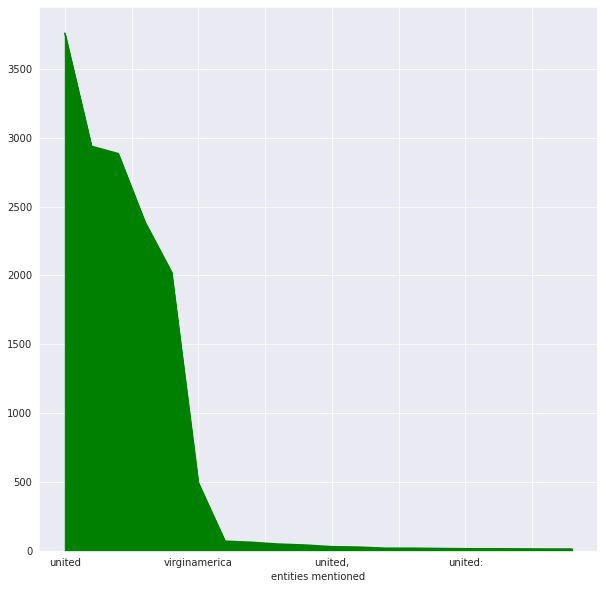

In [157]:
# Converting Array Tags into string and visualising them
split_data = df_data.copy()
split_data,split_data.tags = df_data.iloc[[i for i,j in enumerate(df_data['tags']) for value in j] , :],[value for i in df_data['tags'] for value in i]
split_data.tags.value_counts()[:20].plot.area(figsize=[10,10],color="g").set_xlabel('entities mentioned')
#Maximum tweets mentioned {united airways},then {virginamerica}

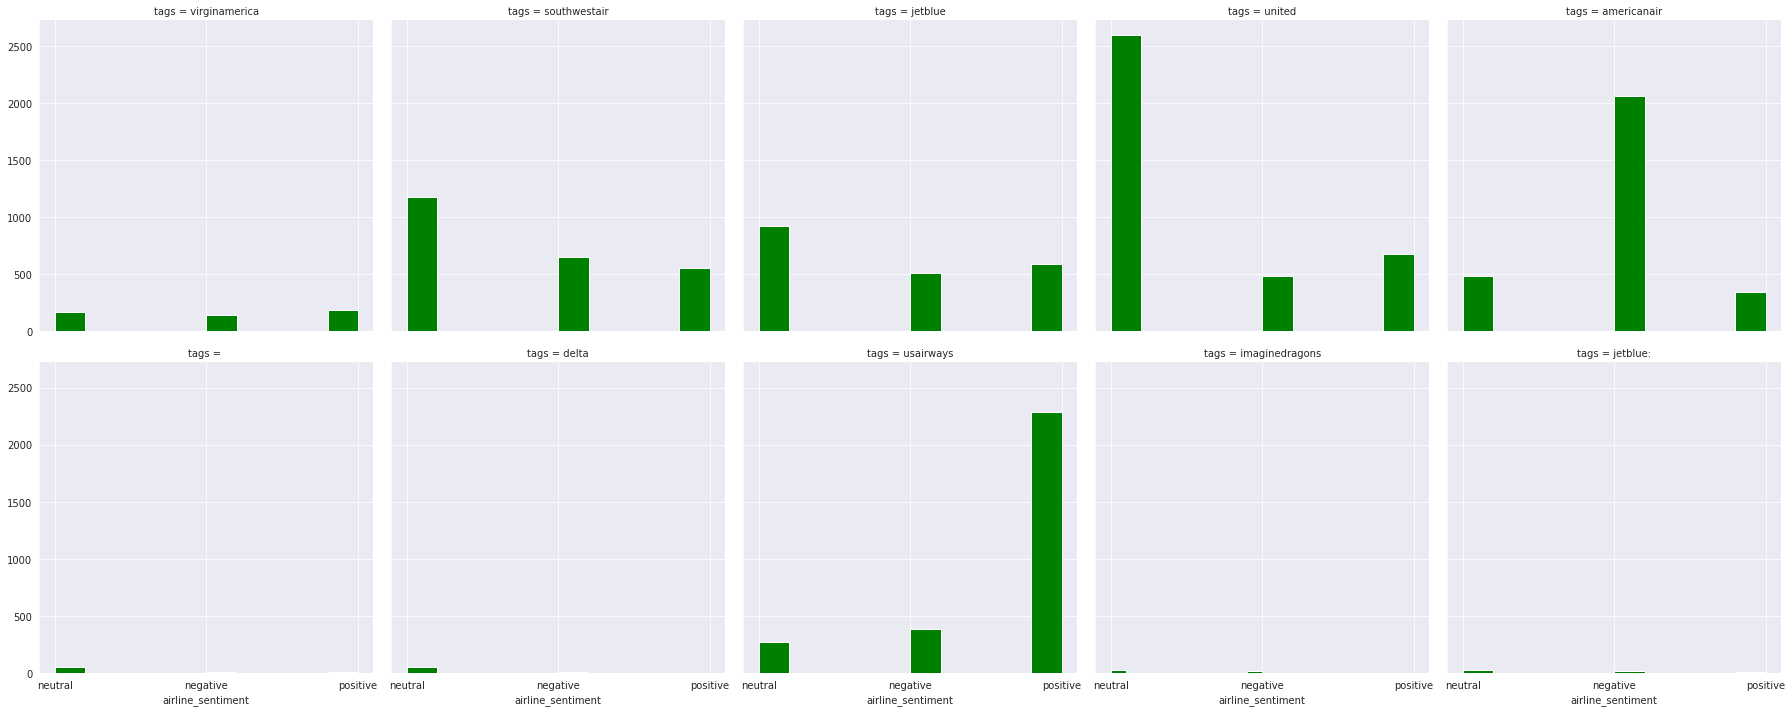

In [158]:
raw_df = split_data[(split_data.tags.isin(split_data.tags.value_counts()[:10].index.to_list()))]
a = sns.FacetGrid(raw_df,col="tags",col_wrap=5, height=5,aspect =1)
a = a.map(plt.hist,'airline_sentiment',color='g')
# virgin america airways have almost equal number of positive negative and neutral
# southwestair have neutral higher means it is ok for airline to continue
# most negative are of american air which shd be a pressing issue
# positive sentiment is maximum for usairways 

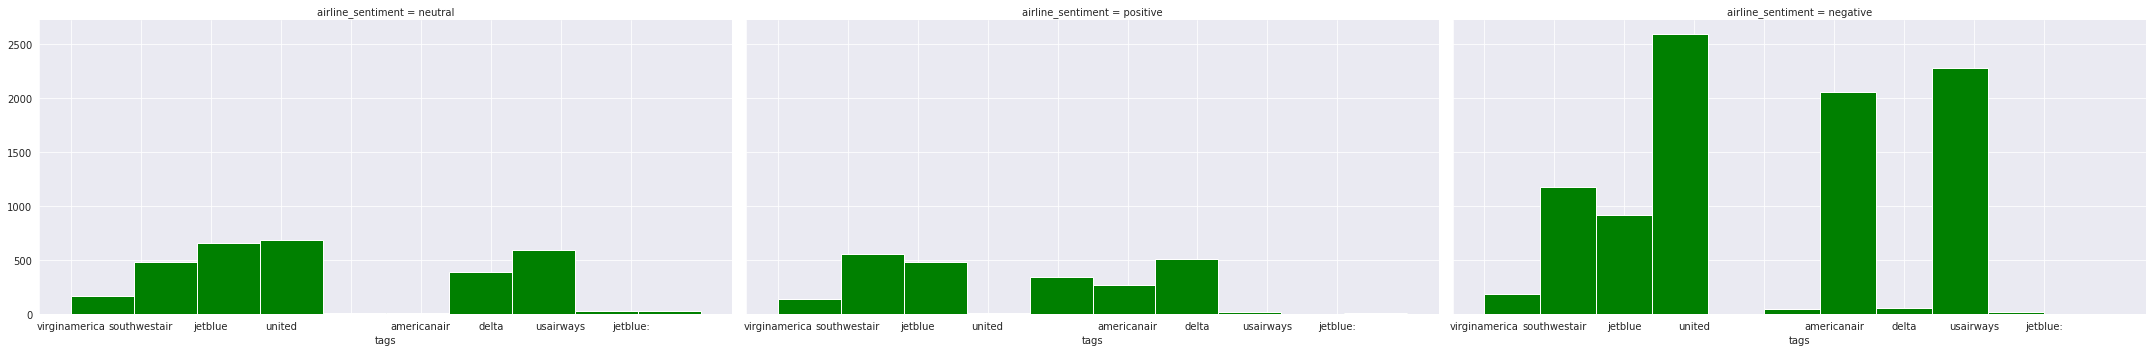

In [159]:
a = sns.FacetGrid(raw_df,col="airline_sentiment",col_wrap=3, height=5,aspect =2)
a = a.map(plt.hist,'tags',color='g')

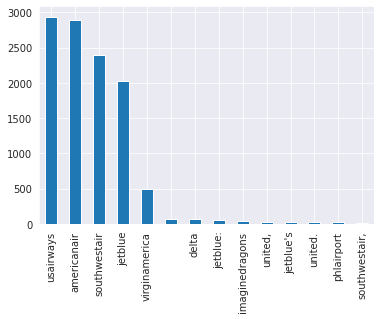

In [160]:
split_data.tags.value_counts()[1:15].plot.bar()

Text(0.5, 0, '')

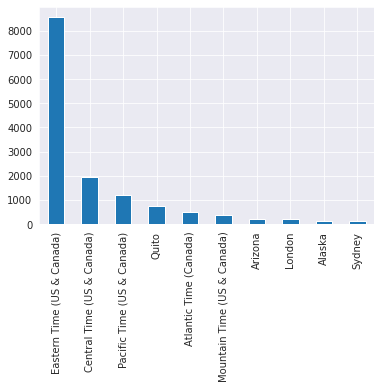

In [161]:
#Top 10 Timezones
df_data['user_timezone'].value_counts().sort_values(ascending=False)[:10].plot.bar().set_xlabel('')

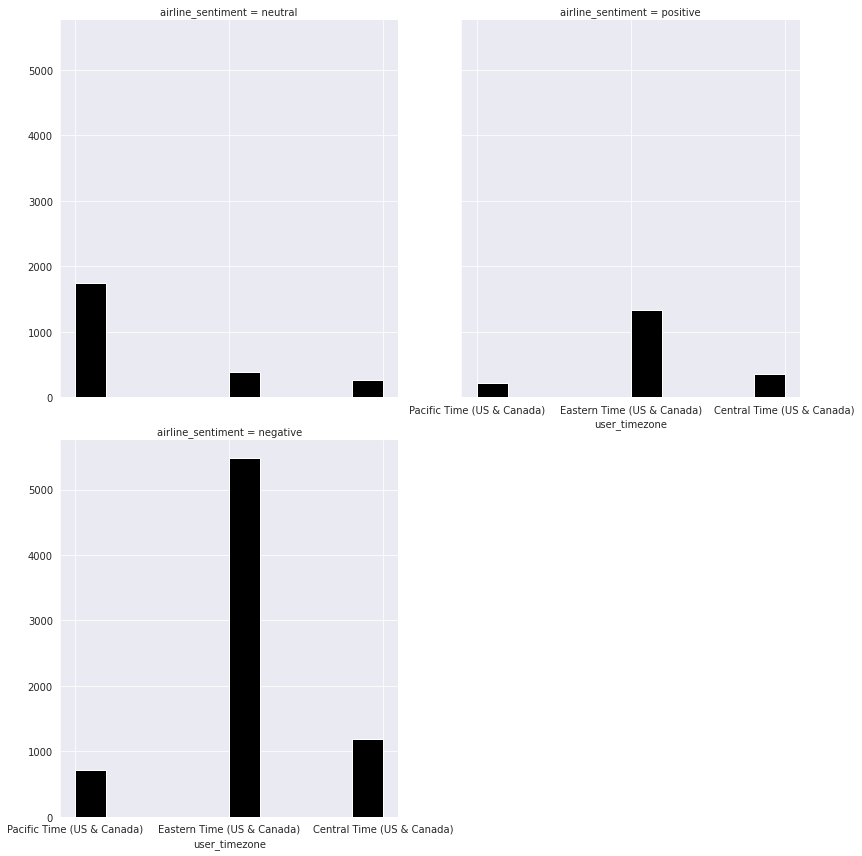

In [162]:
# Top 3 timezones with tweets in comparision to sentiment
a=sns.FacetGrid(df_data[df_data['user_timezone'].isin(df_data.user_timezone.value_counts()[:3].index.to_list())],col='airline_sentiment',col_wrap=2,height=6,)
a=a.map(plt.hist,'user_timezone',color='0')

Text(0.5, 0, 'Sentiments_Division')

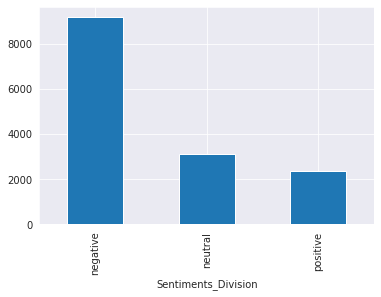

In [163]:
df_data['airline_sentiment'].value_counts().plot.bar().set_xlabel('Sentiments_Division')
# Out of 14500 Tweets it is visible that more than 70% of tweets have negative sentiment
# It can also be a problem which can be more clearly told after topic or entities are separated from text with respect to sentiment

In [ ]:
dictionary_LDA = gensim.corpora.Dictionary(df_data.tokenised_text)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in df_data.tokenised_text]
%time lda_model = models.LdaModel(corpus, num_topics=50,id2word=dictionary_LDA,passes=4,alpha=[0.01]*50,eta=[0.01]*len(dictionary_LDA.keys()))

In [165]:
# CommonTopics With Thier Occurent With Chars
for i,topic in lda_model.show_topics(formatted=True, num_topics=10):
    print(topic)
lda_model[corpus[1]]

0.072*"said" + 0.068*"like" + 0.061*"use" + 0.049*"called" + 0.047*"hung" + 0.047*"fix" + 0.041*"credit" + 0.035*"taking" + 0.033*"looks" + 0.029*"get"
0.148*"ticket" + 0.112*"rebooked" + 0.072*"refund" + 0.033*"fee" + 0.029*"idea" + 0.026*"vacation" + 0.025*"need" + 0.024*"flight" + 0.024*"place" + 0.021*"frustrating"
0.167*"late" + 0.126*"flight" + 0.070*"flightr" + 0.061*"min" + 0.055*"30" + 0.028*"charlotte" + 0.027*"believe" + 0.023*"request" + 0.022*"hours" + 0.022*"minutes"
0.119*"another" + 0.115*"flight" + 0.080*"tonight" + 0.062*"understand" + 0.054*"wrong" + 0.042*"1st" + 0.038*"attendant" + 0.035*"open" + 0.033*"saying" + 0.027*"used"
0.166*"people" + 0.073*"seats" + 0.045*"maybe" + 0.041*"flight" + 0.041*"took" + 0.034*"would" + 0.032*"arrive" + 0.028*"given" + 0.024*"maintenance" + 0.022*"cust"
0.243*"thank" + 0.161*"way" + 0.110*"yes" + 0.071*"sent" + 0.055*"calls" + 0.031*"found" + 0.029*"allow" + 0.025*"handle" + 0.023*"beyond" + 0.022*"phones"
0.126*"let" + 0.104*"cus

[(7, 0.22444446), (14, 0.22444445), (16, 0.44666666)]

In [166]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

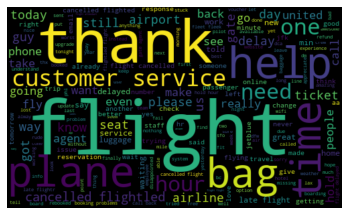

In [167]:
# WordCloudVisualisation
allWords = ' '.join([twts for twts in df_data.text])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear"),plt.axis('off')
plt.show()

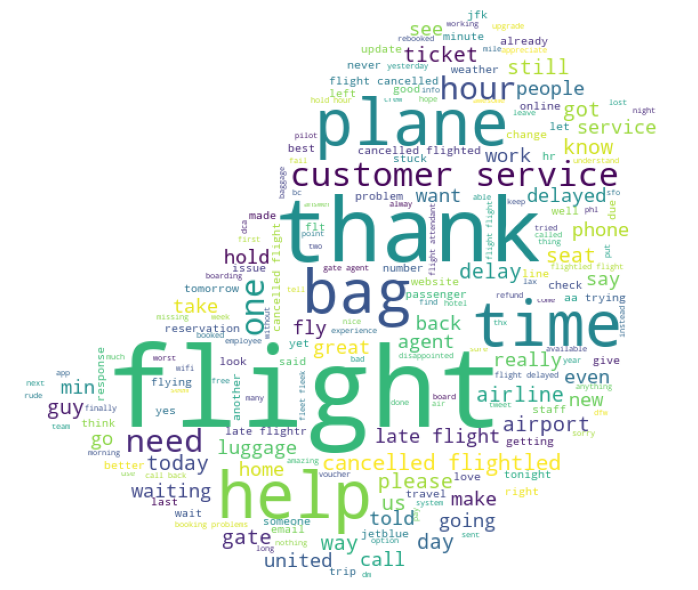

In [168]:
# Most Frequent Words In Whole Text
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/F/O/V/V/E/w/tweeter-bird-hi.png', stream=True).raw))
generate_wordcloud(' '.join([twts for twts in df_data.text]), mask)

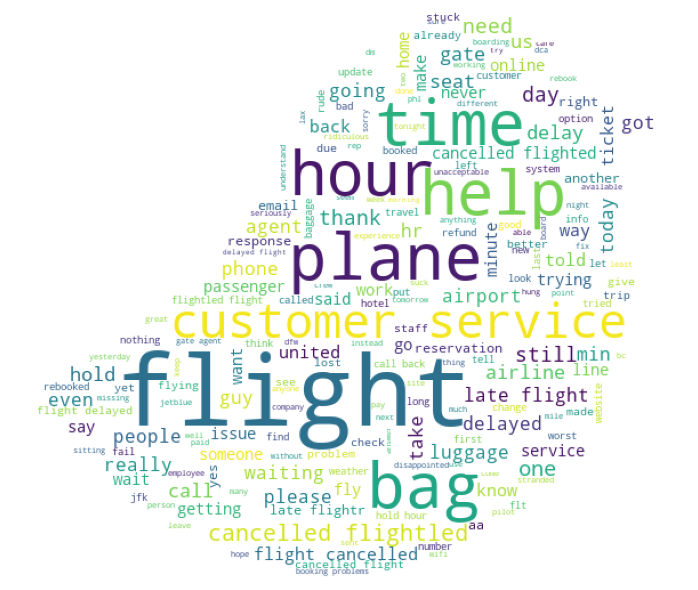

In [169]:
# Most Frequent Words In Negative Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "negative", 'text']]), mask)

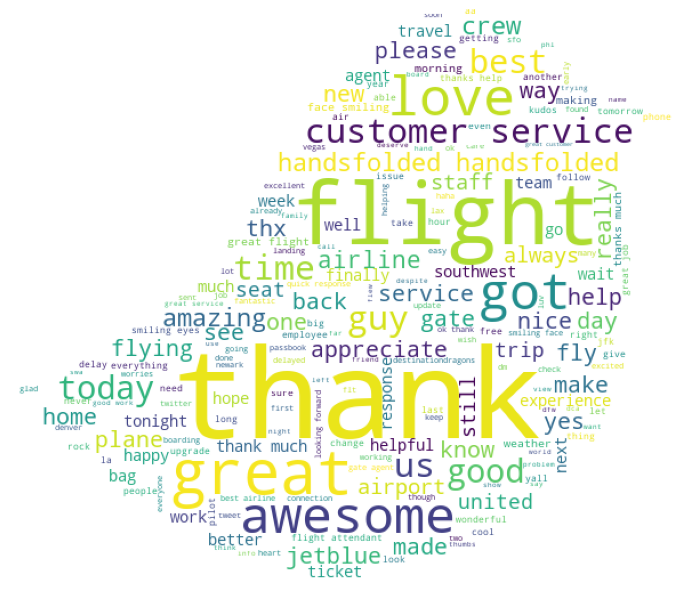

In [170]:
# Most Frequent Word In Positive Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "positive", 'text']]), mask)

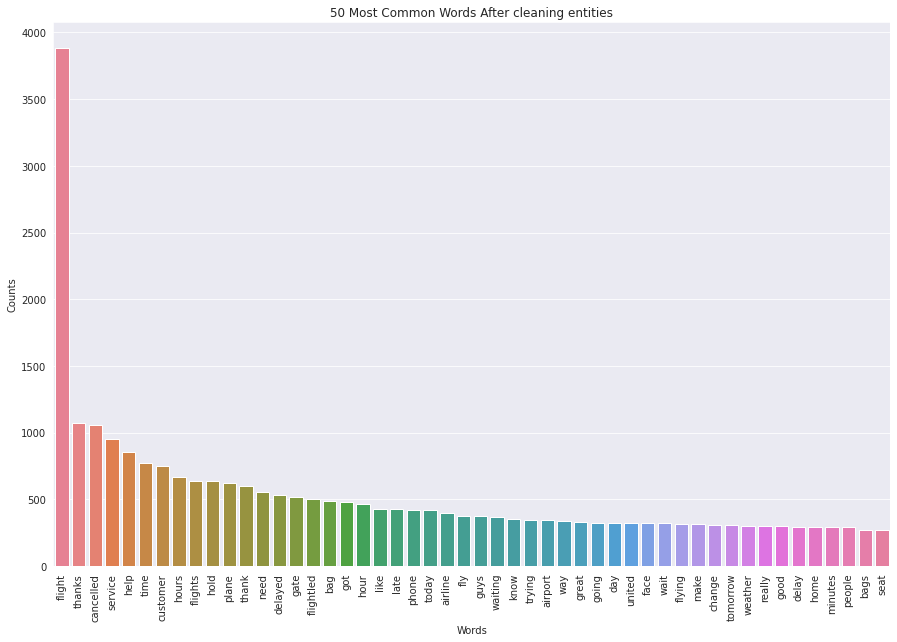

In [171]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_data['text'])

# Visualise the 50 most common words after cleaning entities and text
common_words(count_data, count_vectorizer)

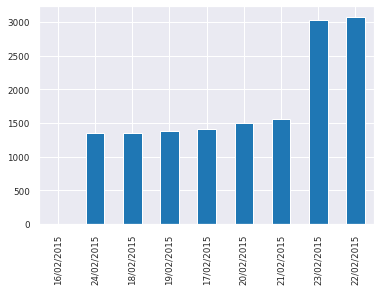

In [172]:
# Tweet Created Frequency v/s Time Distribution
df_data.tweet_created.value_counts().sort_values(ascending=True).plot.bar()

In [173]:
df_data['tweet_created']= pd.to_datetime(df['tweet_created'])
df_data['tweet_time'] = df_data.tweet_created.apply(lambda d : "day" if datetime.datetime.time(d).hour >=6 and datetime.datetime.time(d).hour<18 else "evening or night" )

Text(0.5, 0, 'timing of tweet')

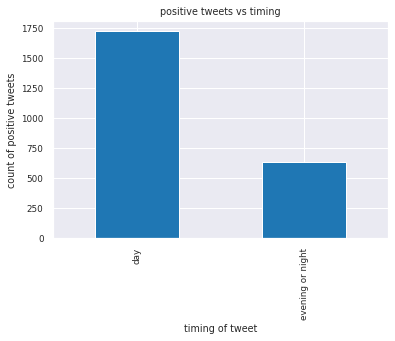

In [174]:
# positive tweets vs timing
f = df_data.tweet_time[df_data['airline_sentiment'] == 'positive'].value_counts().plot.bar()
f.set_title('positive tweets vs timing')
f.set_ylabel('count of positive tweets')
f.set_xlabel('timing of tweet')

Text(0.5, 0, 'timing of tweet')

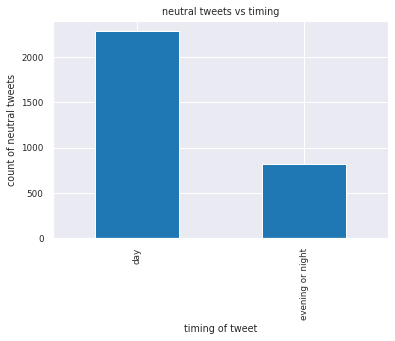

In [175]:
# neutral tweets vs timing
f1 = df_data.tweet_time[df_data['airline_sentiment'] == 'neutral'].value_counts().plot.bar()
f1.set_title('neutral tweets vs timing')
f1.set_ylabel('count of neutral tweets')
f1.set_xlabel('timing of tweet')

Text(0.5, 0, 'timing of tweet')

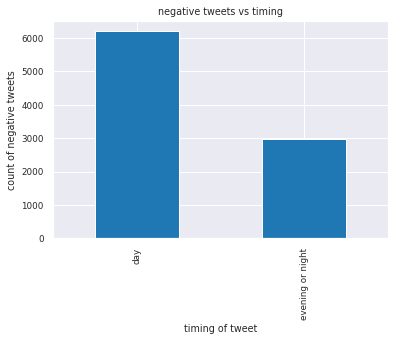

In [176]:
# negative tweets vs timing
f2 = df_data.tweet_time[df_data['airline_sentiment'] == 'negative'].value_counts().plot.bar()
f2.set_title('negative tweets vs timing')
f2.set_ylabel('count of negative tweets')
f2.set_xlabel('timing of tweet')

In [177]:
#US Airlines Fetch
entities = [ i['node']['name'] for i in requests.get('https://cache-api.ranker.com/lists/386932/items?limit=200&offset=0').json()['listItems']]
tags = list(dict.fromkeys([ j for i in df_data.tags for j in i]))

In [178]:
#Positive Negative Neutral Labeled Text Tokenised
positiveTokens = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'positive']['text']]))
negativeTokens = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'negative']['text']]))
neutralTokens  = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'neutral']['text']]))
print("Positive Token - {}\nNegative Tokens - {}\nNeutral Tokens - {}".format(len(positiveTokens),len(negativeTokens),len(neutralTokens)))

Positive Token - 17837
Negative Tokens - 92343
Neutral Tokens - 22589


In [179]:
# Latitude Longitude Map Visualisation 
# One Time Run Code as it'll take approx 1 hour for 1000 rows aka 15 hours for given dataset so we've updated it in out dataset
if(int(input("Run? 0/1\n{0-False, 1-True\n"))):
  geolocator = Nominatim(user_agent="Mozilla/5.0 (Macintosh; U; PPC Mac OS X; fi-fi) AppleWebKit/420+ (KHTML, like Gecko) Safari/419.3")
  geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
  df_data['coordinate'] = df_data['tweet_location'].apply(geocode)
  df_data['latitude'] = df_data.coordinate.apply(lambda x : x.latitude if x!= None else None)
  df_data['longitude'] = df_data.coordinate.apply(lambda x : x.longitude if x!= None else None)

Run? 0/1
{0-False, 1-True
0


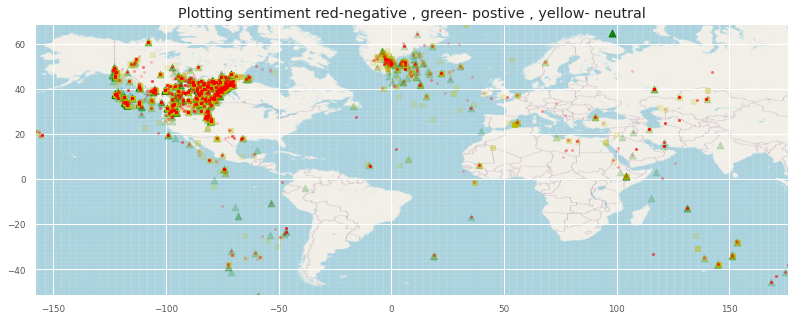

In [180]:
# Geographicial Representation of tweets origin location
BBox = (df_data.longitude.min(),df_data.longitude.max(),df_data.latitude.min(),df_data.latitude.max())
style.use('ggplot')
ruh_m = plt.imread('/content/drive/My Drive/internship/map.jpeg')
fig, sc = plt.subplots(figsize = (15,5))
sc.scatter(df_data[df_data['airline_sentiment']== 'positive'].longitude, df_data[df_data['airline_sentiment']== 'positive'].latitude, zorder=1, alpha= 0.2, c='g', s=50 ,marker= "^")
sc.scatter(df_data[df_data['airline_sentiment']== 'neutral'].longitude, df_data[df_data['airline_sentiment']== 'neutral'].latitude, zorder=1, alpha= 0.2, c='y', s=25 , marker="s")
sc.scatter(df_data[df_data['airline_sentiment']== 'negative'].longitude, df_data[df_data['airline_sentiment']== 'negative'].latitude, zorder=1, alpha= 0.2, c='r', s=5)
sc.set_title('Plotting sentiment red-negative , green- postive , yellow- neutral')
sc.set_xlim(BBox[0],BBox[1])
sc.set_ylim(BBox[2],BBox[3])
sc.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [181]:
#Stanford NER Approach - python distro is obsolete
tagger = nerer.HttpNER(host='127.0.0.1', port=8080)
checker = [tagger.get_entities(i) for i in df.text]
checker.count({})
# Non Functional { Library Support Dropped }

14640

PolyGlot Approach For Entity Recogniton

In [199]:
#For Raw Text
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in df[df['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]
df['PolyGlot_Entities'] = entities

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))
df.head()[['text','PolyGlot_Entities']]

Total 14640
Failed 8962
Success but can be inaccurate 5678


,text,PolyGlot_Entities
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1


In [200]:
#For PRE-Processed Text {HREF LINKS REMOVED, HTML TEXT REMOVED, WORDS LEMMATIZED , PUNCTUATIONS ARE REMOVED}
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in df1[df1['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]
df1['PolyGlot Entities'] = entities

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))
df1.head()[['text','PolyGlot Entities']]

Total 14640
Failed 7971
Success but can be inaccurate 6669


,text,PolyGlot Entities
0,virginamerica what dhepburn said,[[dhepburn]]
1,virginamerica plus you have added commercials ...,1
2,virginamerica i did not today must mean i need...,1
3,virginamerica it is really aggressive to blast...,1
4,virginamerica and it is a really big bad thing...,1


In [201]:
#For Processed Text
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in df_data[df_data['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]

df_data['PolyGlot Entities'] = entities+[1]*(len(df_data)-len(entities))

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))
df_data.head()[['text','PolyGlot Entities']]

Total 14620
Failed 11298
Success but can be inaccurate 3322


,text,PolyGlot Entities
0,said,1
1,plus added commercials experience tacky,1
2,today must mean need take another trip,1
3,really aggressive blast obnoxious entertainmen...,1
4,really big bad thing,1


In [185]:
#NLTK Approach for NER
sentence = df.text[0]
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)
print(entities)
# Promising Approach So Far

(S
  @/NN
  (ORGANIZATION VirginAmerica/NNP)
  What/WP
  @/NNP
  dhepburn/NN
  said/VBD
  ./.)


In [186]:
scount = fcount = 0
df1['NLTK_Entity_Set'] = df1.text.apply(lambda x: NLTK_Entity_Set(x))
print('Basic Formatted Text',scount,fcount,sep=" : ")
scount = fcount = 0
df['NLTK_Entity_Set'] = df.text.apply(lambda x: NLTK_Entity_Set(x))
print('Raw{Orignial} Text',scount,fcount,sep=" : ")
scount = fcount = 0
df_data['NLTK_Entity_Set'] = df_data.text.apply(lambda x: NLTK_Entity_Set(x))
print('Processed_Text',scount,fcount,sep=" : ")

# It's very much clear that original text fetched more natural entities 
# than the formatted or processed text and the subset original text gave are quite promising despite of it's accuracy

Basic Formatted Text : 23 : 14617
Raw{Orignial} Text : 8706 : 5934
Processed_Text : 22 : 14618


In [195]:
# Applying Extracted Entities in columns and replacing others to None
df['Entities_Extracted'] = df.NLTK_Entity_Set.apply(extractor)
indexes = df.Entities_Extracted.value_counts()[:5].index
df.Entities_Extracted = df.Entities_Extracted.apply(lambda x: x if x in indexes  else 1 )
print("Correctly Filled Entities in {} columns".format(df['Entities_Extracted'].value_counts()[1:6].sum()))
print("Success Percentage {} columns".format(df['Entities_Extracted'].value_counts()[1:6].sum()/df.shape[0]*100))
print("Fail Percentage {} columns".format(df['Entities_Extracted'].value_counts()[:1].sum()/df.shape[0]*100))

Correctly Filled Entities in 8563 columns
Success Percentage 58.490437158469945 columns
Fail Percentage 41.509562841530055 columns


In [196]:
# Twitter API Un-Paid Request Rate Limit Exceeding So Not Usable At Current Scenario
import twitter
from twitter_creds import *
api = twitter.Api()
api = twitter.Api(consumer_key=consumer_key,consumer_secret=consumer_secret,access_token_key=access_token_key,access_token_secret=access_token_secret)
try: print(api.GetUser(screen_name = 'virginamerica').name)
except Exception as e: print(e.message[0]['message'])

Virgin America


<h1> <strong>Ongoing work {Models, Entity}  </strong></h1>

Will try to fill missing values after nltk ner from polyglot if any matches

In [197]:
temp_df = df[df.Entities_Extracted == 1]
scount = fcount = 0
temp_df['NLTK_Entity_Set'] = temp_df.text.apply(lambda x: NLTK_Entity_Set(x))
print('Basic Formatted Text',scount,fcount,sep=" : ")

Basic Formatted Text : 1837 : 4240


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [198]:
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in temp_df[temp_df['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]
temp_df['PolyGlot_Entities'] = entities+[1]*(len(temp_df)-len(entities))

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))
temp_df.head()[['text','PolyGlot_Entities']]

Total 6077
Failed 4236
Success but can be inaccurate 1841


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,PolyGlot_Entities
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1
18,I ❤️ flying @VirginAmerica. ☺️👍,[[☺️]]
35,Nice RT @VirginAmerica: Vibe with the moodligh...,1
70,@virginamerica Need to change reservation. Hav...,1
98,@virginamerica What is your phone number. I ca...,1


In [202]:
re.findall(r'@[A-Za-z]\w+',df.text[0])

['@VirginAmerica', '@dhepburn']

# Models

In [203]:
df_target = df_data.airline_sentiment.replace({'positive':1,'neutral':0,"negative":-1})
df_target.value_counts()

-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [204]:
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
corpus  = tfidfconverter.fit_transform(df_data['text'].astype(str)).toarray()

In [205]:
#Spliiting the data into tain and test set.
X_train, X_test, Y_train, Y_test = train_test_split(corpus, df_target, test_size=0.25, stratify=df_target,random_state=30)

# Logistic Resgression

lr =LogisticRegression()
lr.fit(X_train,Y_train)
y_pred = lr.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test,y_pred))
print("\nAccuracy of Logisticregression Model: {}\n".format(accuracy_score(Y_test, y_pred)))
print(classification_report(Y_test,y_pred))

Confusion Matrix
[[2123  127   44]
 [ 372  338   65]
 [ 134   83  374]]

Accuracy of Logisticregression Model: 0.7745901639344263

              precision    recall  f1-score   support

          -1       0.81      0.93      0.86      2294
           0       0.62      0.44      0.51       775
           1       0.77      0.63      0.70       591

    accuracy                           0.77      3660
   macro avg       0.73      0.66      0.69      3660
weighted avg       0.76      0.77      0.76      3660



In [206]:
# Random Forest Classifier

RFC =RandomForestClassifier()
RFC.fit(X_train,Y_train)
y_pred =RFC.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test,y_pred))
print("\nAccuracy of RandomForestClassifier Model: {}\n".format(accuracy_score(Y_test, y_pred)))
print(classification_report(Y_test,y_pred))  

Confusion Matrix
[[2085  152   57]
 [ 375  322   78]
 [ 155   74  362]]

Accuracy of RandomForestClassifier Model: 0.7565573770491804

              precision    recall  f1-score   support

          -1       0.80      0.91      0.85      2294
           0       0.59      0.42      0.49       775
           1       0.73      0.61      0.67       591

    accuracy                           0.76      3660
   macro avg       0.70      0.65      0.67      3660
weighted avg       0.74      0.76      0.74      3660



In [207]:
# Support Vector Machine
sup =svm.SVC()
sup.fit(X_train,Y_train)
y_pred = sup.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test,y_pred))
print("\nAccuracy of SupportVectorMachine Model: {}\n".format(accuracy_score(Y_test, y_pred)))
print(classification_report(Y_test,y_pred))  

Confusion Matrix
[[2190   69   35]
 [ 440  269   66]
 [ 157   52  382]]

Accuracy of SupportVectorMachine Model: 0.7762295081967213

              precision    recall  f1-score   support

          -1       0.79      0.95      0.86      2294
           0       0.69      0.35      0.46       775
           1       0.79      0.65      0.71       591

    accuracy                           0.78      3660
   macro avg       0.76      0.65      0.68      3660
weighted avg       0.77      0.78      0.75      3660



In [208]:
# Decision Tree Classifer
DTC =DecisionTreeClassifier()
DTC.fit(X_train,Y_train)
y_pred =DTC.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test,y_pred))
print("\nAccuracy of DecisionTreeClassifier Model: {}\n".format(accuracy_score(Y_test, y_pred)))
print(classification_report(Y_test,y_pred))

Confusion Matrix
[[1870  278  146]
 [ 325  357   93]
 [ 138   92  361]]

Accuracy of DecisionTreeClassifier Model: 0.7071038251366121

              precision    recall  f1-score   support

          -1       0.80      0.82      0.81      2294
           0       0.49      0.46      0.48       775
           1       0.60      0.61      0.61       591

    accuracy                           0.71      3660
   macro avg       0.63      0.63      0.63      3660
weighted avg       0.70      0.71      0.71      3660

